# Evidence estimation in a Bayesian cognitive model


In [1]:
%load_ext autoreload
%autoreload 2

import os

# For JAX, we can use CPU (set SELECTED_DEVICE to empty (''), or one of the available GPUs)
SELECTED_DEVICE = '3'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [3]


In [2]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)  # Do we need this here? -> it seems we do for the LML computations (otherwise NaNs get introduced), but not for performance

import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import blackjax
import pandas as pd
import jax.scipy.special as jsp

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import pyreadr as pr

from distrax._src.distributions.distribution import Distribution

import os
import sys
import requests
import time

from blackjax import normal_random_walk, nuts

import bamojax
from bamojax.base import Node, Model
from bamojax.samplers import gibbs_sampler, mcmc_sampler
from bamojax.inference import SMCInference

print('Python version:       ', sys.version)
print('Jax version:          ', jax.__version__)
print('BlackJax version:     ', blackjax.__version__)
print('Distrax version:      ', dx.__version__)
print('BaMoJax version:      ', bamojax.__version__)
print('Jax default backend:  ', jax.default_backend())
print('Jax devices:          ', jax.devices())

SMALL_SIZE = 14
MEDIUM_SIZE = 16
LARGE_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

Python version:        3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
Jax version:           0.4.35
BlackJax version:      1.2.4
Distrax version:       0.1.5
BaMoJax version:       0.1.0+16.g08c3781
Jax default backend:   gpu
Jax devices:           [CudaDevice(id=0)]


In [5]:
def download_to_disk(url, filepath):
    response = requests.get(url)
    if response.status_code == 200:
        with open(filepath, 'wb') as file:
            file.write(response.content)
        print('File downloaded successfully!')
    else:
        print(f'Failed to download the file. Status code: {response.status_code}')

#
data_busemeyer_url = 'https://osf.io/download/5vws6/'  # DataBusemeyerNoNA.rdata on https://osf.io/f9cq4/; contains IGT data
data_busemeyer_file = 'DataBusemeyerNoNA.rdata'

data_steingroever_url = 'https://osf.io/download/bmnsv/'  # contains Steingroever's importance sampling marginal likelihoods
data_steingroever_file = 'DataSteingroever.rdata'

lml_url = 'https://osf.io/download/txnbs/' # ind_LogMargLik.txt on https://osf.io/f9cq4/; contains Gronau's bridge sampling estmates
lml_file = 'ind_LogMargLik.txt'

download_to_disk(data_busemeyer_url, data_busemeyer_file)
download_to_disk(data_steingroever_url, data_steingroever_file)
download_to_disk(lml_url, lml_file)

File downloaded successfully!
File downloaded successfully!
File downloaded successfully!


In [3]:
data_file = pr.read_r('DataBusemeyerNoNA.rdata')
choices = jnp.asarray(data_file['choice'].to_numpy().astype(int)) - 1  # Python zero-indexing
losses = jnp.asarray(data_file['lo'].to_numpy())
wins = jnp.asarray(data_file['wi'].to_numpy())

N, T = choices.shape
K = 4

print(wins.shape)
print(losses.shape)
print(choices.shape)

(30, 100)
(30, 100)
(30, 100)


In [4]:
def ev_link_fn(w, a, c_raw, choices, wins, losses):
    c = 4*c_raw - 2.0
    ev = jnp.zeros((K, ))
    logits = jnp.ones((T, K))  # softmax of uniform is = [1/K, 1/K, ...]

    def for_body(t, carry):
        ev_, logits_ = carry
        theta = (0.1*(t+1))**c  
        current_utility = (1-w) * wins[t] + w*losses[t]
        k = choices[t]
        ev_ = ev_.at[k].add(a * (current_utility - ev_[k]))
        logits_ = logits_.at[t + 1, :].set(theta * ev_)
        return (ev_, logits_)
    
    #
    _, logits = jax.lax.fori_loop(0, T - 1, for_body, (ev, logits))

    return dict(logits=logits)

#
def make_ev_model(subject):
    EVModel = Model(f'Expectance valence model, subject {subject}')
    w_node = EVModel.add_node('w', distribution=dx.Beta(alpha=1.0, beta=1.0))
    a_node = EVModel.add_node('a', distribution=dx.Beta(alpha=1.0, beta=1.0))
    c_raw_node = EVModel.add_node('c_raw', distribution=dx.Beta(alpha=1.0, beta=1.0))
    wins_node = EVModel.add_node('wins', observations=wins[subject, :])
    loss_node = EVModel.add_node('losses', observations=losses[subject, :])

    # Note that in RL examples we often have a form of autoregression. Here, `choices` are observed, but also feed back into the model.
    choice_node = EVModel.add_node('choices', 
                                observations=choices[subject, :], 
                                distribution=dx.Categorical, 
                                link_fn=ev_link_fn, 
                                parents=dict(w=w_node, 
                                                a=a_node, 
                                                c_raw=c_raw_node, 
                                                choices=choices[subject,:], 
                                                wins=wins_node, 
                                                losses=loss_node))
    return EVModel

#

In [ ]:
%%time
def wrapper(key, subject):
    evmodel = make_ev_model(subject=subject)
    mcmc_params = dict(sigma=stepsize*jnp.eye(evmodel.get_model_size()))
    mcmc = mcmc_sampler(evmodel, mcmc_kernel=normal_random_walk, mcmc_parameters=mcmc_params)
    engine = SMCInference(model=evmodel, mcmc_kernel=mcmc, num_particles=num_particles, num_mutations=num_mcmc_steps, num_chains=num_chains)
    result = engine.run(key)
    return result['lml']

#
num_chains = 1
num_mcmc_steps = 100
num_particles = 1000
stepsize = 0.01

subjects = jnp.arange(N)
key = jrnd.PRNGKey(42)
keys = jrnd.split(key, N)
lml_scores = jax.vmap(wrapper)(keys, subjects)

print(lml_scores)

[-130.11476832 -104.3861437  -115.2574332  -117.76698274 -104.57315714
 -136.53919714 -137.82958722 -129.83331334 -141.63624626  -89.72069373
 -133.22591469 -140.69361439 -140.38424115 -133.12219643 -132.89766306
 -137.18260349 -135.88678616 -110.27566632 -106.57249805 -141.47076234
 -140.70655446 -109.69175541 -119.00489292 -138.47274467 -131.47910512
 -122.36959444 -125.09983963 -140.8105361  -138.36698996 -128.69834024]
CPU times: user 38.1 s, sys: 15.5 s, total: 53.6 s
Wall time: 54.6 s


Correlation between SMC and Importance sampling is 1.000
Correlation between SMC and Bridge sampling is 1.000


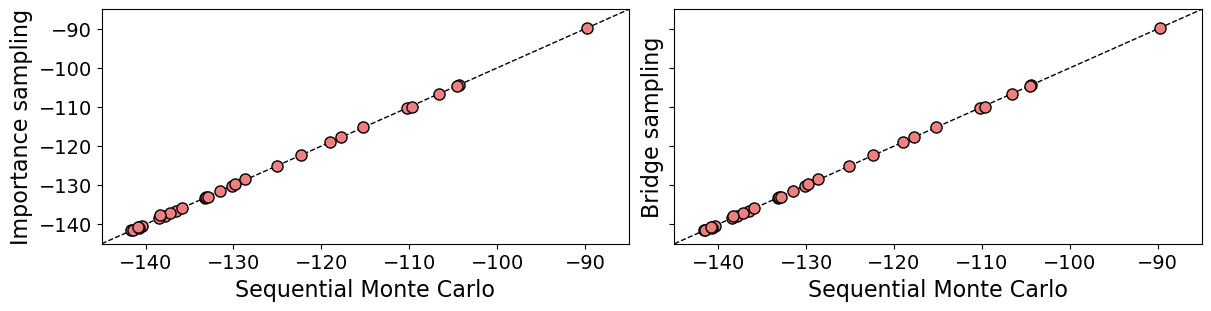

In [8]:
from pathlib import Path

lims = [-145, -85]
bs_lmls_file = open(f'ind_LogMargLik.txt')
lines = bs_lmls_file.readlines()
bs_lmls = jnp.array([float(line.split()[1]) for line in lines[1:]])

is_lmls_file = pr.read_r(os.path.join(Path(os.getcwd()).parents[0], 'cognitive_models/DataSteingroever.rdata'))
is_lmls = jnp.squeeze(jnp.log(pr.read_r(f'/scratch/big/home/maxhin/Documents/Code/SMC tutorial/EV/data/margLike_SteingroeverEtAl2016_importance_sampling.Rdata')['marg.like'].to_numpy()))

baselines = [is_lmls, bs_lmls]

baseline_names = ['Importance sampling', 'Bridge sampling']

_, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, constrained_layout=True, figsize=(12, 3))
for i, (baseline, name, ax) in enumerate(zip(baselines, baseline_names, axes)):
    print(f'Correlation between SMC and {name} is {jnp.corrcoef(lml_scores, baseline)[0, 1]:0.3f}')
    ax.scatter(lml_scores, baseline, c='lightcoral', edgecolors='k', s=64, zorder=10)
    ax.plot(lims, lims, ls='--', c='k', lw=1, zorder=5)
    ax.set_xlabel('Sequential Monte Carlo')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_ylabel(name)

plt.savefig(f'/home/maxhin/Documents/Code/SMC tutorial/Review1 results/individual_lml_scores_figure.pdf', 
            bbox_inches='tight', pad_inches=0.0)

## The hierarchical expectance valence model

In [9]:
def hev_link_fn(w, a, c, choices, wins, losses):
    """
    This function was optimized from a previous implementation by ChatGPT-o1
    """
    c = 4*c - 2.0
    ev0 = jnp.zeros((N, K))
    row_inds = jnp.arange(N)
    init_logit = jnp.ones((N, K))  # shape (N, K) for time t=0

    def scan_step(carry, t):
        ev_ = carry
        current_utility = (1 - w) * wins[:, t] + w * losses[:, t]
        chosen_decks_ev = ev_.at[row_inds, choices[:, t]]
        ev_updated = ev_.at[row_inds, choices[:, t]].set(
            chosen_decks_ev.get() + a * (current_utility - chosen_decks_ev.get())
        )
        theta = (0.1 * (t + 1)) ** c
        logits_tplus1 = theta[:, None] * ev_updated
        return ev_updated, logits_tplus1
    
    #
    carry_init = ev0

    _, logits_seq = jax.lax.scan(scan_step, carry_init, jnp.arange(T-1))

    logits_full = jnp.concatenate([init_logit[None], logits_seq], axis=0)  
    logits_full = jnp.swapaxes(logits_full, 0, 1)  

    return dict(logits=logits_full)

#

HEVModel = Model(f'Hierarchical expectance valence model')
mu_w_node = HEVModel.add_node('mu_w', dx.Normal(loc=0.0, scale=1.0))
mu_a_node = HEVModel.add_node('mu_a', dx.Normal(loc=0.0, scale=1.0))
mu_c_node = HEVModel.add_node('mu_c', dx.Normal(loc=0.0, scale=1.0))

sigma_w_node = HEVModel.add_node('sigma_w', dx.Uniform(low=0.0, high=1.5))
sigma_a_node = HEVModel.add_node('sigma_a', dx.Uniform(low=0.0, high=1.5))
sigma_c_node = HEVModel.add_node('sigma_c', dx.Uniform(low=0.0, high=1.5))

w_node = HEVModel.add_node('w', distribution=dx.Normal, parents=dict(loc=mu_w_node, scale=sigma_w_node), shape=(N, ), bijector=tfb.NormalCDF())
a_node = HEVModel.add_node('a', distribution=dx.Normal, parents=dict(loc=mu_a_node, scale=sigma_a_node), shape=(N, ), bijector=tfb.NormalCDF())
c_node = HEVModel.add_node('c', distribution=dx.Normal, parents=dict(loc=mu_c_node, scale=sigma_c_node), shape=(N, ), bijector=tfb.NormalCDF())

wins_node = HEVModel.add_node('wins', observations=wins)
loss_node = HEVModel.add_node('losses', observations=losses)

choice_node = HEVModel.add_node('choices', 
                                observations=choices, 
                                distribution=dx.Categorical, 
                                link_fn=hev_link_fn, 
                                parents=dict(w=w_node, 
                                             a=a_node, 
                                             c=c_node, 
                                             choices=choices,
                                             wins=wins_node, 
                                             losses=loss_node))

HEVModel.print_gibbs()

Gibbs structure:
mu_w                : p(w | sigma_w, mu_w) p(mu_w)
sigma_w             : p(w | sigma_w, mu_w) p(sigma_w)
w                   : p(choices | wins, losses, w, c, choices_choices, a) p(w | sigma_w, mu_w)
mu_a                : p(a | sigma_a, mu_a) p(mu_a)
sigma_a             : p(a | sigma_a, mu_a) p(sigma_a)
a                   : p(choices | wins, losses, w, c, choices_choices, a) p(a | sigma_a, mu_a)
mu_c                : p(c | sigma_c, mu_c) p(mu_c)
sigma_c             : p(c | sigma_c, mu_c) p(sigma_c)
c                   : p(choices | wins, losses, w, c, choices_choices, a) p(c | sigma_c, mu_c)


In [20]:
%%time
key = jrnd.PRNGKey(1234)

num_chains = 1
num_mcmc_steps = 200
num_particles = 2000

# adaptively determining stepsizes is an important upcoming feature!
step_fns = dict(mu_w=normal_random_walk, 
                mu_a=normal_random_walk, 
                mu_c=normal_random_walk, 
                w=normal_random_walk, 
                a=normal_random_walk, 
                c=normal_random_walk,
                sigma_w=normal_random_walk,
                sigma_a=normal_random_walk,
                sigma_c=normal_random_walk)
step_fn_params = dict(mu_w=dict(sigma=0.5), 
                      mu_a=dict(sigma=0.5), 
                      mu_c=dict(sigma=0.5), 
                      w=dict(sigma=0.005), 
                      a=dict(sigma=0.005), 
                      c=dict(sigma=0.005),
                      sigma_w=dict(sigma=0.2),
                      sigma_a=dict(sigma=0.2),
                      sigma_c=dict(sigma=0.2))

gibbs = gibbs_sampler(HEVModel, step_fns=step_fns, step_fn_params=step_fn_params)

engine = SMCInference(model=HEVModel, mcmc_kernel=gibbs, num_particles=num_particles, num_mutations=num_mcmc_steps, num_chains=num_chains)
result = engine.run(key)

final_state = result['final_state']
lml = result['lml']
final_info = result['final_info']
num_adapt = result['n_iter']

print('Log marginal likelihood:', lml)
for var in step_fns.keys():
    print(f'Acceptance rate {var}: {jnp.mean(final_info.update_info[var].is_accepted)}')

Log marginal likelihood: -3820.989320072407
Acceptance rate mu_w: 0.2684274911880493
Acceptance rate mu_a: 0.27447250485420227
Acceptance rate mu_c: 0.2798675000667572
Acceptance rate w: 0.576200008392334
Acceptance rate a: 0.4239625036716461
Acceptance rate c: 0.7011724710464478
Acceptance rate sigma_w: 0.42458999156951904
Acceptance rate sigma_a: 0.4373925030231476
Acceptance rate sigma_c: 0.4439699947834015
CPU times: user 7min 33s, sys: 5min, total: 12min 34s
Wall time: 12min 36s


Note: as discussed in [Hinne, 2024](https://osf.io/preprints/psyarxiv/swjtu_v2), to get a reliable LML estimate, one needs to sample for much longer, but the posterior is already approximated well.

Visualize posterior

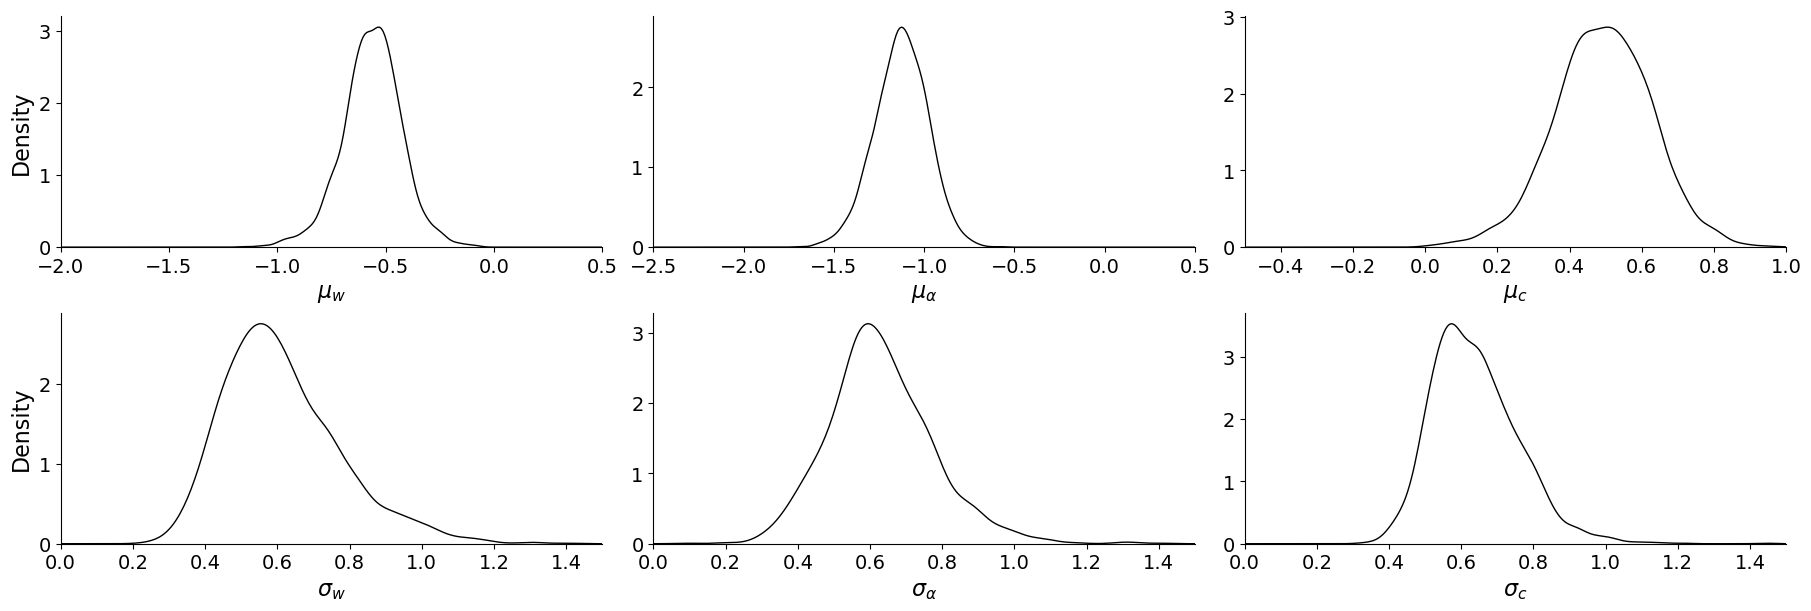

In [21]:
from jax.scipy.stats import gaussian_kde

_, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 6), constrained_layout=True)
limits = [[-2, 0.5], [-2.5, 0.5], [-0.5, 1]]
names = [r'$\mu_w$', r'$\mu_\alpha$', r'$\mu_c$']
res = 300

for ax, v, limit, name in zip(axes[0, :], ['w', 'a', 'c'], limits, names):
    samples = final_state.particles[f'mu_{v}'].flatten()
    pdf = gaussian_kde(samples)
    input_range = jnp.linspace(*limit, num=res)
    ax.plot(input_range, pdf(input_range), lw=1, color='k')
    ax.set_xlim(limit)
    ax.set_ylim(bottom=0)
    ax.set_xlabel(name)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

limits = [[0.0, 1.5], [0.0, 1.5], [0.0, 1.5]]
names = [r'$\sigma_w$', r'$\sigma_\alpha$', r'$\sigma_c$']

for ax, v, limit, name in zip(axes[1, :], ['w', 'a', 'c'], limits, names):
    samples = final_state.particles[f'sigma_{v}'].flatten()
    pdf = gaussian_kde(samples)
    input_range = jnp.linspace(*limit, num=res)
    ax.plot(input_range, pdf(input_range), lw=1, color='k')
    ax.set_xlim(limit)
    ax.set_ylim(bottom=0)
    ax.set_xlabel(name)

for ax in axes.flatten():
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
for ax in axes[:, 0]:
    ax.set_ylabel('Density');